In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(["ggplot", "../.default.mplstyle"])

import scipy
import distribution

%matplotlib inline

In [2]:
from importlib import reload

In [3]:
import scipy.special

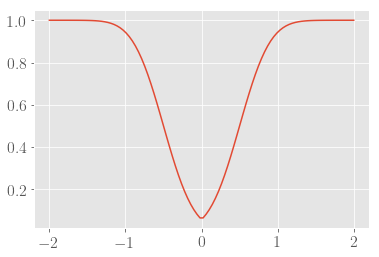

In [4]:
L = 1
M = 1
mu = .5
sigma = .1

x = np.linspace(-2,2, 100)

z = - np.sqrt(1/sigma/2) * (L * np.abs(x) - M + mu)

plt.plot(x, .5 * scipy.special.erfc(z))

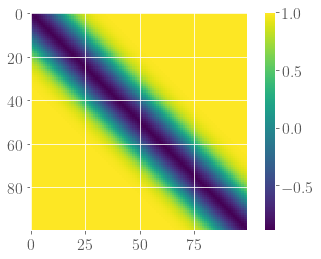

In [5]:
d = np.abs(x[:, None] - x[None, :])

z = np.sqrt(1/sigma/2) * (L * d - M + mu)

plt.imshow(scipy.special.erf(z));
plt.colorbar()

In [17]:
import objective
o = objective.Ackley(d=3)
x = o.sample_space(5)

In [21]:
dexact = np.zeros((x.shape[0], x.shape[0]))

for i in range(x.shape[0]):
    for j in range(x.shape[0]):
        dexact[i, j] = np.sqrt(np.power(x[i, :] - x[j, :], 2).sum())

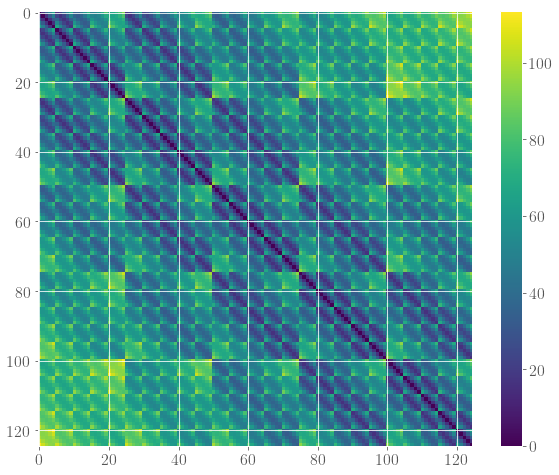

In [25]:
x = o.sample_space(5)
x = x.reshape((x.shape[0], 1, x.shape[1]))
d = np.sqrt(np.power(x - x.swapaxes(0,1), 2).sum(2))

plt.figure(figsize=(10,8))
plt.imshow(d)
plt.colorbar()

In [26]:
np.allclose(d, dexact)

True

## dist 

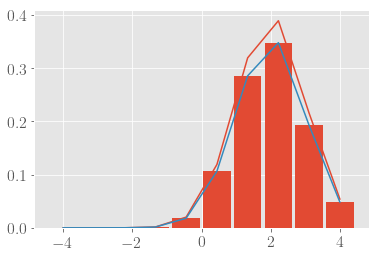

In [14]:
reload(distribution)

z = np.linspace(-4, 4, 10)
nrm = scipy.stats.norm(2, 1)
d = distribution.Discrete(z, nrm.pdf(z))
plt.bar(z, d.pdf(z))
plt.plot(z, nrm.pdf(z))
plt.plot(z, d.npdfs)

In [15]:
d.pdf(z)

array([5.43203561e-09, 7.57925845e-07, 4.79893168e-05, 1.37884726e-03,
       1.79780050e-02, 1.06370347e-01, 2.85596840e-01, 3.47968525e-01,
       1.92389014e-01, 4.82696688e-02])

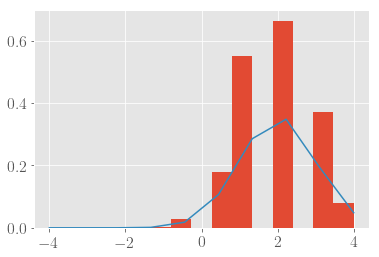

In [16]:
plt.hist(d.sample(1000), density=True)
plt.plot(z, d.pdf(z))

In [17]:
d.pdf(z).sum()

1.0

In [18]:
nrm.pdf(z).sum()

1.1185278012773372

# Test in code 

In [9]:
import modeler
import aquisition

## d=1

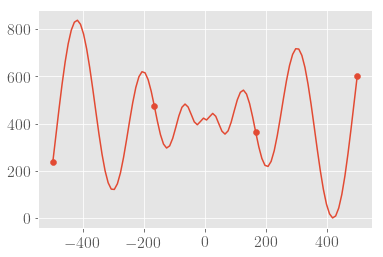

In [20]:
o = objective.Schwefel(d=1)
n = 4
x = o.sample_space(n)
y = o(x)[:, None]

pn = 100
predx = o.sample_space(pn)
predy = o(predx)

plt.scatter(x, y)
plt.plot(predx, predy)

In [1067]:
builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(x, y, resample=2)
m

 /Users/pdt2/dev/stochastic-sampling-bayesian-optimization/venv/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


GP_regression.,value,constraints,priors
rbf.variance,1.000081832499104,+ve,
rbf.lengthscale,0.058891580934377456,+ve,
Gaussian_noise.variance,0.0,+ve fixed,


 /Users/pdt2/dev/stochastic-sampling-bayesian-optimization/venv/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


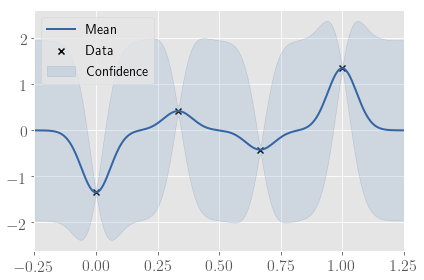

In [1068]:
m.plot()

(14.35352501713997, array(-1.35045817))

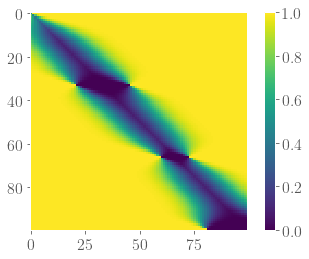

In [1058]:
a = aquisition.SBUCB_LocalPenalty(sample_size=3)
a._precompute(m, builder, predx, None, True, None, None)

plt.imshow(a.gamma)
plt.colorbar()
plt.grid(False)

a.L, a.M

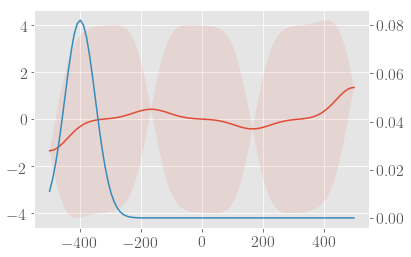

In [1110]:
nrm = scipy.stats.norm(-400, 50)
dists = [distribution.Discrete(predx, nrm.pdf(predx))]*o.d

pdf = np.prod([dists[i].pdf(predx[:, i]) for i in range(x.shape[1])], 0)

pdf = pdf[:, 0]



mu, var = m.predict(builder.transform(predx))
mu = mu[:, 0]
var = var[:, 0]

plt.plot(predx, mu)
plt.fill_between(predx[:, 0], mu - 4 * np.sqrt(var), mu + 4 * np.sqrt(var), alpha=.1)
# plt.scatter(x, y, c='k')

plt.twinx()
plt.plot(predx, pdf, color='C1');
plt.grid(False)

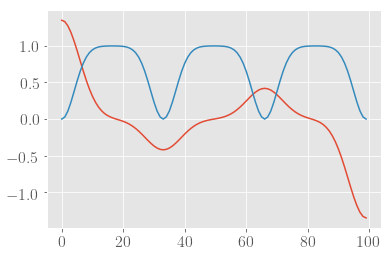

In [1111]:
mu, var = m.predict(builder.transform(predx))
mu = mu[:, 0]
var = var[:, 0]

plt.plot(-mu)
plt.plot(var)

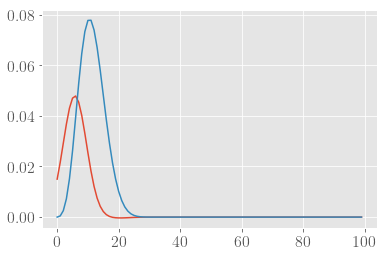

In [1112]:
plt.plot(-pdf*mu);
plt.plot(pdf*var);

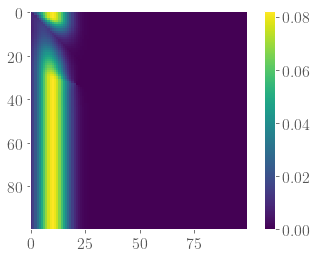

In [1113]:
plt.imshow(pdf[None, :] * a.gamma)
plt.colorbar()
plt.grid(False)

Text(0.5, 0, '$x_i$')

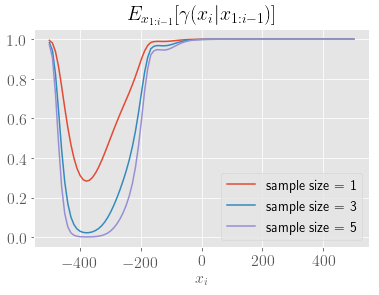

In [1114]:
gamma = np.sum(pdf[None, :] * a.gamma, 1)
[plt.plot(predx, np.power(gamma, i), label="sample size = {}".format(i)) for i in range(1, 7, 2)]
plt.legend()
plt.title("$E_{x_{1:i-1}}[\gamma(x_i | x_{1:i-1})]$");
plt.xlabel("$x_i$")

Text(0.5, 0, '$x_i$')

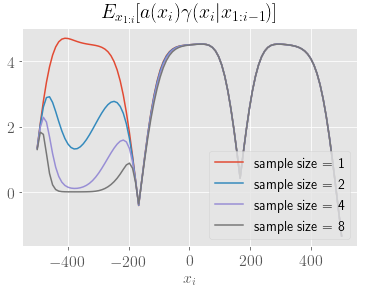

In [1121]:
alpha = -mu + a.beta(x.shape[0], 100) * np.sqrt(var)
[plt.plot(predx, alpha*np.power(gamma, i), label="sample size = {}".format(1+i)) for i in [0, 1, 3, 7]]
plt.legend()
plt.title("$E_{x_{1:i}}[a(x_i)\gamma(x_i | x_{1:i-1})]$");
plt.xlabel("$x_i$")

50.135045816103556


[50, 15, 14, 14, 13]

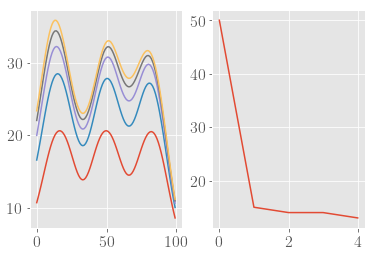

In [1075]:
mus = np.linspace(o.range[0][0], o.range[0][1], 100)
aq = np.zeros(mus.shape[0])

s = (mu.max() - mus.min())*.1
print(s)

am = []

reload(aquisition)
plt.subplot(121)
for ss in range(1, 6):
    a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
    a._precompute(m, builder, predx, None, True, None, None)

    for i, m1 in enumerate(mus):
        dists = [distribution.Normal(m1, s)]
        
        nrm = scipy.stats.norm(m1, s)
        dists = [distribution.Discrete(predx, nrm.pdf(predx))]

        aq[i] = a._compute(m, builder, predx, mu, var, dists, True, x.shape[0], predx.shape[0])

    plt.plot(aq)
    
    am.append(np.argmax(aq))
    
plt.subplot(122)
plt.plot(am);
am

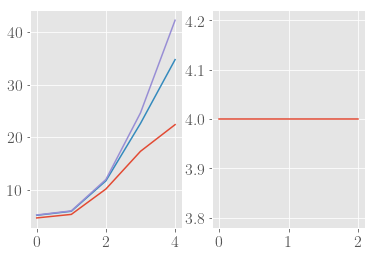

In [1076]:
diff = o.range[0][1] - o.range[0][0]
stds = np.logspace(np.log10(diff*.001), np.log10(diff*.1), 5)

am = []

reload(aquisition)
plt.subplot(121)
for ss in range(1, 4):
    aq = np.zeros(stds.shape[0])
    
    a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
    a._precompute(m, builder, predx, None, True, None, None)

    for i, std in enumerate(stds):        
        nrm = scipy.stats.norm(mus[13], std)
        dists = [distribution.Discrete(predx, nrm.pdf(predx))]

        aq[i] = a._compute(m, builder, predx, mu, var, dists, True, x.shape[0], predx.shape[0])

    plt.plot(aq)
    
    am.append(np.argmax(aq))
    
plt.subplot(122)
plt.plot(am);

## d=2

In [10]:
def extent(x):
    
    return (x[:, 0].min(), x[:, 0].max(), x[:, 1].min(), x[:, 1].max())

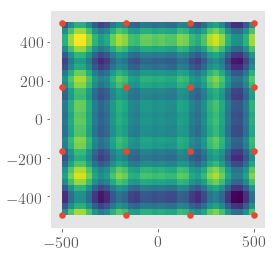

In [43]:
o = objective.Schwefel(d=2)
n = 4
x = o.sample_space(n)
y = o(x)[:, None]

pn = 32
predx = o.sample_space(pn)
predy = o(predx)

plt.imshow(predy.reshape((pn, pn)), extent=extent(predx))
plt.scatter(x[:,0], x[:,1])
plt.grid(False)

In [44]:
o.d

2

In [45]:
builder = modeler.Modeler(o, noiseless=True, kernel=o.kernel)

m = builder.build(x, y, resample=2)
m

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
 /Users/pdt2/dev/stochastic-sampling-bayesian-optimization/venv/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


GP_regression.,value,constraints,priors
sum.rbf.variance,0.6537041093334306,+ve,
sum.rbf.lengthscale,0.17081582831147474,+ve,"Ga(1, 1)"
sum.rbf_1.variance,0.6536993519044325,+ve,
sum.rbf_1.lengthscale,0.17081439479081034,+ve,"Ga(1, 1)"
Gaussian_noise.variance,0.0,+ve fixed,


 /Users/pdt2/dev/stochastic-sampling-bayesian-optimization/venv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /Users/pdt2/dev/stochastic-sampling-bayesian-optimization/venv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


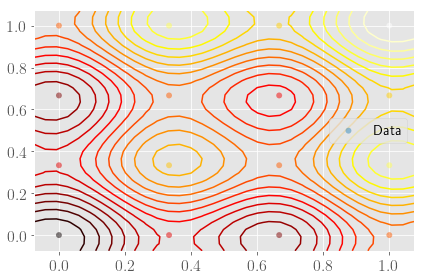

In [46]:
m.plot()

In [47]:
reload(aquisition)

<module 'aquisition' from '/Users/pdt2/dev/stochastic-sampling-bayesian-optimization/simulations/aquisition.py'>

In [48]:
a = aquisition.SBUCB_LocalPenalty(sample_size=5)
mu, var = m.predict(builder.transform(predx))
mu = mu[:, 0]
var = var[:, 0]

In [49]:
a._precompute(m, builder, predx, mu, var, True, x.shape[0], predx.shape[0], )

(7.667641995500356, array(-1.90983627))

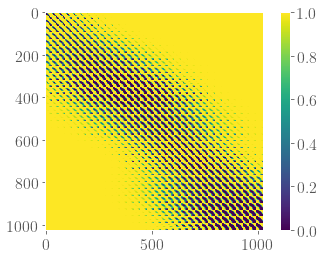

In [50]:
plt.imshow(a.gamma)
plt.colorbar()
plt.grid(False)

a.L, a.M

In [77]:
reload(distribution)

<module 'distribution' from '/Users/pdt2/dev/stochastic-sampling-bayesian-optimization/simulations/distribution.py'>

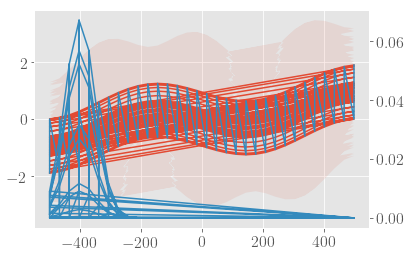

In [83]:
nrm = scipy.stats.norm(-400, 50)
dists = [distribution.Discrete(predx[:, i], nrm.pdf(predx[:, i])) for i in range(o.d)]

pdf = np.prod([dists[i].pdf(predx[:, i]) for i in range(x.shape[1])], 0)

mu, var = m.predict(builder.transform(predx))
mu = mu[:, 0]
var = var[:, 0]

plt.plot(predx, mu)
plt.fill_between(predx[:, 0], mu - 4 * np.sqrt(var), mu + 4 * np.sqrt(var), alpha=.1)
# plt.scatter(x, y, c='k')

plt.twinx()
plt.plot(predx, pdf, color='C1');
plt.grid(False)

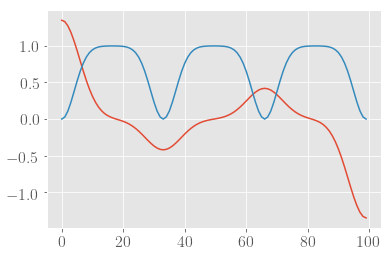

In [1111]:
mu, var = m.predict(builder.transform(predx))
mu = mu[:, 0]
var = var[:, 0]

plt.plot(-mu)
plt.plot(var)

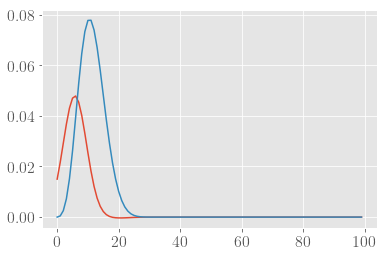

In [1112]:
plt.plot(-pdf*mu);
plt.plot(pdf*var);

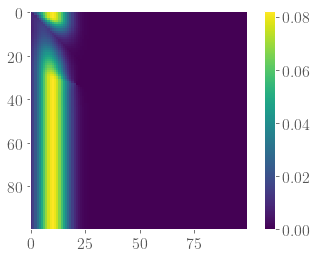

In [1113]:
plt.imshow(pdf[None, :] * a.gamma)
plt.colorbar()
plt.grid(False)

Text(0.5, 0, '$x_i$')

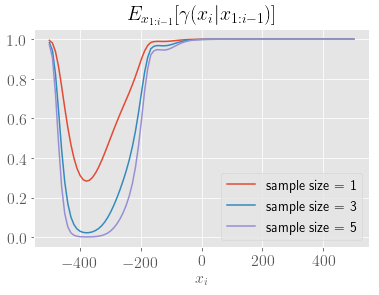

In [1114]:
gamma = np.sum(pdf[None, :] * a.gamma, 1)
[plt.plot(predx, np.power(gamma, i), label="sample size = {}".format(i)) for i in range(1, 7, 2)]
plt.legend()
plt.title("$E_{x_{1:i-1}}[\gamma(x_i | x_{1:i-1})]$");
plt.xlabel("$x_i$")

Text(0.5, 0, '$x_i$')

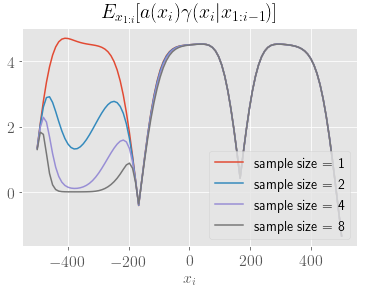

In [1121]:
alpha = -mu + a.beta(x.shape[0], 100) * np.sqrt(var)
[plt.plot(predx, alpha*np.power(gamma, i), label="sample size = {}".format(1+i)) for i in [0, 1, 3, 7]]
plt.legend()
plt.title("$E_{x_{1:i}}[a(x_i)\gamma(x_i | x_{1:i-1})]$");
plt.xlabel("$x_i$")

In [967]:
stds

array([  200.71743249,   755.49460302,  2843.65980626, 10703.45315698,
       40287.48770559])

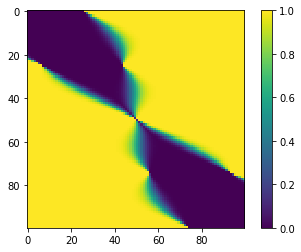

In [774]:
plt.imshow(np.power(a.gamma, 3))
plt.colorbar()

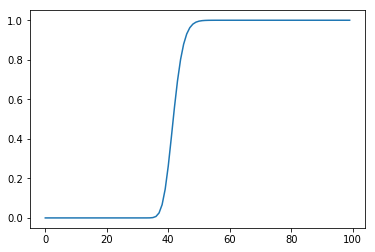

In [783]:
plt.plot(np.power(a.gamma, 10)[10, :]);

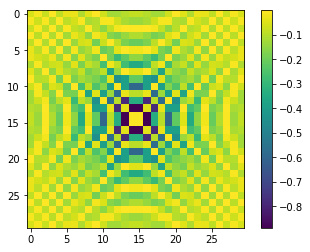

In [585]:
import GPy

o = objective.Dropwave(d=2)
n = 30
x = o.sample_space(n)
y = o(x)[:, None]

plt.imshow(y.reshape((n, n)))
plt.colorbar()

In [586]:
import modeler
builder = modeler.Modeler(o,noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

# m = GPy.models.GPRegression(x, y, GPy.kern.RBF(o.d, ARD=True))
m = builder.build(x, y, resample=0)
m.optimize()
m

GP_regression.,value,constraints,priors
rbf.variance,0.3160396599941816,+ve,
rbf.lengthscale,0.2399997521214115,+ve,
Gaussian_noise.variance,0.6430947068438708,+ve,


 /Users/pdt2/dev/stochastic-sampling-bayesian-optimization/venv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /Users/pdt2/dev/stochastic-sampling-bayesian-optimization/venv/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


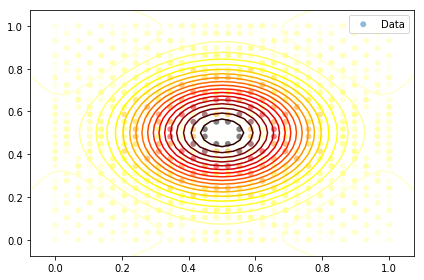

In [587]:
m.plot()

In [588]:
import aquisition
from importlib import reload
reload(aquisition)
a = aquisition.SBUCB_LocalPenalty(sample_size=2)

In [589]:
a._precompute(m, builder, x, None, True, None, None)
a.L, a.M

(10.237332972779889, array(-5.05357395))

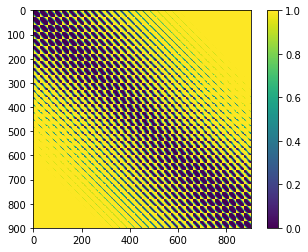

In [590]:
plt.imshow(a.gamma)
plt.colorbar()

(900,)

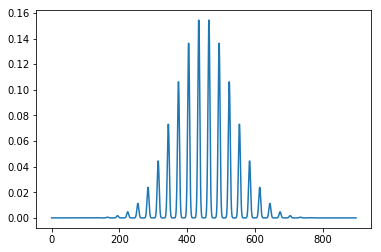

In [591]:
import distribution
dists = [distribution.Normal(0,1)]*o.d

pdf = np.prod([dists[i].pdf(x[:, i]) for i in range(x.shape[1])], 0)
plt.plot(pdf)
pdf.shape

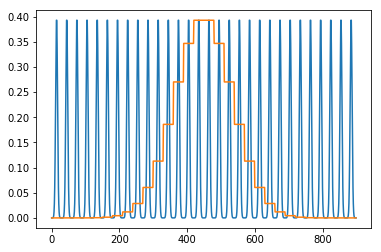

In [592]:
[plt.plot(dists[i].pdf(x[:, i])) for i in range(x.shape[1])];

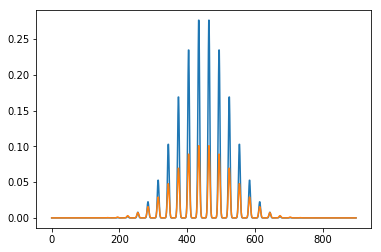

In [593]:
mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]
plt.plot(-pdf*mu);
plt.plot(pdf*var);

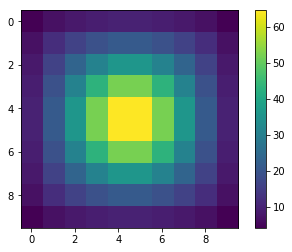

In [594]:
mus = np.linspace(o.range[0][0], o.range[0][1], 10)
aq = np.zeros((mus.shape[0], mus.shape[0]))

s = (mus.max() - mus.min())*.1

for i, m1 in enumerate(mus):
    for j, m2 in enumerate(mus):
        dists = [distribution.Normal(m1, s), distribution.Normal(m2, s)]
        aq[i, j] = a._compute(m, builder, x, mu, var, dists, True, 1, 100)
        
plt.imshow(aq)
plt.colorbar()

In [571]:
s

1.024